# Lab 05 : GatedGCNs with DGL - demo


Deep Graph Library (DGL) 

https://docs.dgl.ai/


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_name = '01_GatedGCNs_DGL.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==0.3 #DGL

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import dgl
from dgl import DGLGraph
from dgl.data import MiniGCDataset

import time
import numpy as np
import networkx as nx

import os
import pickle

import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
    

In [2]:

# select GPU 
gpu_id = 0  
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  

if torch.cuda.is_available():
    print('cuda available with GPU:',torch.cuda.get_device_name(0))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
else:
    print('cuda not available')
    gpu_id = -1
    server_id = -1
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    
# GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


cuda not available


# Collate function to prepare graphs

In [3]:

# collate function 
def collate(samples):
    graphs, labels = map(list, zip(*samples)) # samples is a list of pairs (graph, label).
    labels = torch.tensor(labels)
    tab_sizes_n = [ graphs[i].number_of_nodes() for i in range(len(graphs))] # graph sizes
    tab_snorm_n = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_n ]
    snorm_n = torch.cat(tab_snorm_n).sqrt() # normalization constant for better optimization
    tab_sizes_e = [ graphs[i].number_of_edges() for i in range(len(graphs))] # nb of edges
    tab_snorm_e = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_e ]
    snorm_e = torch.cat(tab_snorm_e).sqrt() # normalization constant for better optimization
    batched_graph = dgl.batch(graphs) # batch graphs
    return batched_graph, labels, snorm_n, snorm_e


# create artifical data feature (= in degree) for each node
def create_artificial_features(dataset):
    for (graph,_) in dataset:
        graph.ndata['feat'] = graph.in_degrees().view(-1, 1).float()
        graph.edata['feat'] = torch.ones(graph.number_of_edges(),1)
    return dataset


# use artifical graph dataset of DGL
trainset = MiniGCDataset(8, 10, 20)
trainset = create_artificial_features(trainset)
print(trainset[0])


(DGLGraph(num_nodes=14, num_edges=42,
         ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), 0)


In [4]:

save_dataset = False
save_dataset = True
data_folder = 'data/'
if save_dataset == True:
    
    # train, test, val datasets
    trainset = MiniGCDataset(350, 10, 20)
    testset = MiniGCDataset(100, 10, 20)
    valset = MiniGCDataset(100, 10, 20)
    data_loader = DataLoader(trainset, batch_size=20, shuffle=True, collate_fn=collate)

    trainset = create_artificial_features(trainset)
    testset = create_artificial_features(testset)
    valset = create_artificial_features(valset)

    with open(data_folder + "artificial_dataset.pickle","wb") as f:
        pickle.dump([trainset,testset,valset],f)
        
else:
    
    with open(data_folder + "artificial_dataset.pickle","rb") as f:
        f = pickle.load(f)
        trainset = f[0]
        testset = f[1]
        valset = f[1]
    print('train, test, val sizes :',len(trainset),len(testset),len(valset))
    

train, test, val sizes : 350 100 100


# Visualize graph dataset

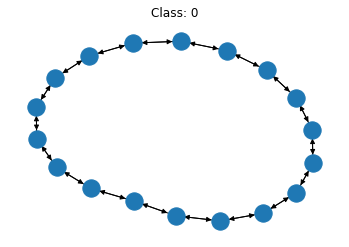

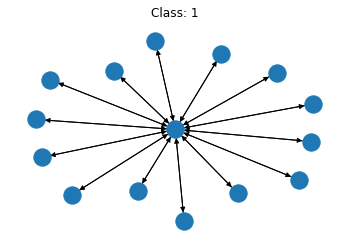

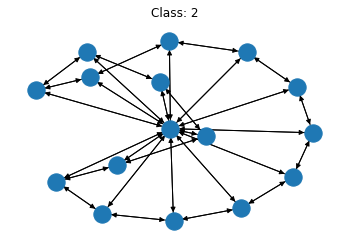

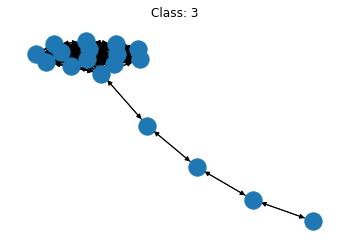

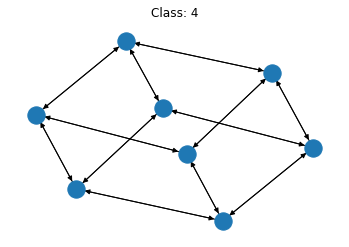

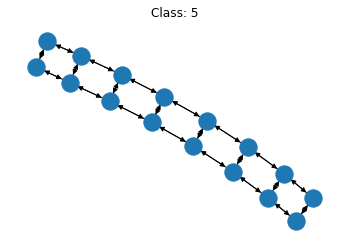

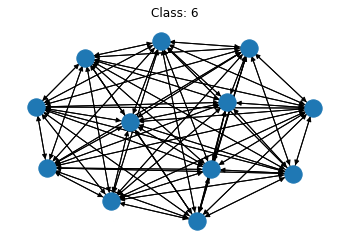

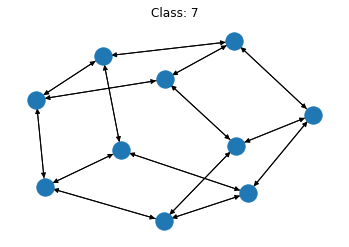

In [5]:

visualset = MiniGCDataset(8, 10, 20)

# visualise the 8 classes of graphs
for c in range(8):
    graph, label = visualset[c] 
    fig, ax = plt.subplots()
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()


# GatedGCNs


Residual Gated Graph ConvNets, X Bresson, T Laurent, ICLR 2017, [arXiv:1711.07553](https://arxiv.org/pdf/1711.07553v2.pdf) <br>


\begin{eqnarray}
h_i^{\ell+1} &=& h_i^{\ell} + \text{ReLU} \left( A^\ell h_i^{\ell} +  \sum_{j\sim i} \eta(e_{ij}^{\ell}) \odot B^\ell h_j^{\ell} \right), \quad \eta(e_{ij}^{\ell}) = \frac{\sigma(e_{ij}^{\ell})}{\sum_{j'\sim i} \sigma(e_{ij'}^{\ell}) + \varepsilon} \\
e_{ij}^{\ell+1} &=& e^\ell_{ij} + \text{ReLU} \Big( C^\ell e_{ij}^{\ell} + D^\ell h^{\ell+1}_i + E^\ell h^{\ell+1}_j  \Big)
\end{eqnarray}


In [6]:

class MLP_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = F.relu(y)
        y = self.FC_layers[self.L](y)
        return y

        
        
class GatedGCN_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(GatedGCN_layer, self).__init__()
        self.A = nn.Linear(input_dim, output_dim, bias=True)
        self.B = nn.Linear(input_dim, output_dim, bias=True)
        self.C = nn.Linear(input_dim, output_dim, bias=True)
        self.D = nn.Linear(input_dim, output_dim, bias=True)
        self.E = nn.Linear(input_dim, output_dim, bias=True)
        self.bn_node_h = nn.BatchNorm1d(output_dim)
        self.bn_node_e = nn.BatchNorm1d(output_dim)

    def message_func(self, edges):
        Bh_j = edges.src['Bh'] 
        e_ij = edges.data['Ce'] +  edges.src['Dh'] + edges.dst['Eh'] # e_ij = Ce_ij + Dhi + Ehj
        edges.data['e'] = e_ij
        return {'Bh_j' : Bh_j, 'e_ij' : e_ij}

    def reduce_func(self, nodes):
        Ah_i = nodes.data['Ah']
        Bh_j = nodes.mailbox['Bh_j']
        e = nodes.mailbox['e_ij'] 
        sigma_ij = torch.sigmoid(e) # sigma_ij = sigmoid(e_ij)
        h = Ah_i + torch.sum( sigma_ij * Bh_j, dim=1 ) / torch.sum( sigma_ij, dim=1 )  # hi = Ahi + sum_j eta_ij * Bhj    
        return {'h' : h}
    
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        h_in = h # residual connection
        e_in = e # residual connection
        
        g.ndata['h']  = h 
        g.ndata['Ah'] = self.A(h) 
        g.ndata['Bh'] = self.B(h) 
        g.ndata['Dh'] = self.D(h)
        g.ndata['Eh'] = self.E(h) 
        g.edata['e']  = e 
        g.edata['Ce'] = self.C(e) 
        g.update_all(self.message_func,self.reduce_func) 
        h = g.ndata['h'] # result of graph convolution
        e = g.edata['e'] # result of graph convolution
        
        h = h* snorm_n # normalize activation w.r.t. graph node size
        e = e* snorm_e # normalize activation w.r.t. graph edge size
        
        h = self.bn_node_h(h) # batch normalization  
        e = self.bn_node_e(e) # batch normalization  
        
        h = F.relu(h) # non-linear activation
        e = F.relu(e) # non-linear activation
        
        h = h_in + h # residual connection
        e = e_in + e # residual connection
        
        return h, e
    
    
class GatedGCN_Net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GatedGCN_Net, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.embedding_e = nn.Linear(1, hidden_dim)
        self.GatedGCN_layers = nn.ModuleList([ GatedGCN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        # input embedding
        h = self.embedding_h(h)
        e = self.embedding_e(e)
        
        # graph convnet layers
        for GGCN_layer in self.GatedGCN_layers:
            h,e = GGCN_layer(g,h,e,snorm_n,snorm_e)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    
    
    def loss(self, y_scores, y_labels):
        loss = nn.CrossEntropyLoss()(y_scores, y_labels)
        return loss        
        
    def accuracy(self, scores, targets):
        scores = scores.detach().argmax(dim=1)
        acc = (scores==targets).float().sum().item()
        return acc
    
    def gpu_memory(self, memory):
        if torch.cuda.is_available():
            current_memory = torch.cuda.memory_allocated() /1e9
            if current_memory > memory :
                memory = current_memory
        return memory
    
    def update(self, lr):       
        update = torch.optim.Adam( self.parameters(), lr=lr )
        return update
    
    def update_learning_rate(self, optimizer, lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        return optimizer
    

    

# network parameters
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 100
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 2

# instantiate network
net = GatedGCN_Net(net_parameters)
net = net.to(device)
print(net)


GatedGCN_Net(
  (embedding_h): Linear(in_features=1, out_features=100, bias=True)
  (embedding_e): Linear(in_features=1, out_features=100, bias=True)
  (GatedGCN_layers): ModuleList(
    (0): GatedGCN_layer(
      (A): Linear(in_features=100, out_features=100, bias=True)
      (B): Linear(in_features=100, out_features=100, bias=True)
      (C): Linear(in_features=100, out_features=100, bias=True)
      (D): Linear(in_features=100, out_features=100, bias=True)
      (E): Linear(in_features=100, out_features=100, bias=True)
      (bn_node_h): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_node_e): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): GatedGCN_layer(
      (A): Linear(in_features=100, out_features=100, bias=True)
      (B): Linear(in_features=100, out_features=100, bias=True)
      (C): Linear(in_features=100, out_features=100, bias=True)
      (D): Linear(in_features=100, out_features=1

# Test forward pass

In [7]:

train_loader = DataLoader(trainset, batch_size=10, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
print(batch_snorm_n.size())
print(batch_snorm_e.size())

batch_x = batch_graphs.ndata['feat'].to(device)
print('batch_x',batch_x.size())
#print(batch_x)

batch_e = batch_graphs.edata['feat'].to(device)
print('batch_e',batch_e.size())
#print(batch_e)

batch_snorm_n = batch_snorm_n.to(device)
print('batch_snorm_n',batch_snorm_n.size())

batch_snorm_e = batch_snorm_e.to(device)
print('batch_snorm_e',batch_snorm_e.size())

batch_scores = net.forward(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
print(batch_scores.size())

batch_labels = batch_labels.to(device)
accuracy = net.accuracy(batch_scores,batch_labels)
print(accuracy)


DGLGraph(num_nodes=144, num_edges=926,
         ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})
tensor([1, 6, 7, 4, 3, 4, 6, 2, 4, 0])
torch.Size([144, 1])
torch.Size([926, 1])
batch_x torch.Size([144, 1])
batch_e torch.Size([926, 1])
batch_snorm_n torch.Size([144, 1])
batch_snorm_e torch.Size([926, 1])
torch.Size([10, 8])
0.0


# Test backward pass

In [8]:

# optimization parameters
opt_parameters = {}
opt_parameters['lr'] = 0.0005

# Loss
loss = net.loss(batch_scores, batch_labels)

# Backward pass
lr = opt_parameters['lr']
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer.zero_grad()
loss.backward()
optimizer.step()


# Train one epoch

In [9]:

def train_one_epoch(net, data_loader):
    """
    train one epoch
    """
    net.train()
    epoch_loss = 0
    epoch_train_acc = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat'].to(device)
        batch_e = batch_graphs.edata['feat'].to(device)
        batch_snorm_n = batch_snorm_n.to(device)
        batch_snorm_e = batch_snorm_e.to(device)
        batch_labels = batch_labels.to(device)
        batch_scores = net.forward(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
        gpu_mem = net.gpu_memory(gpu_mem)
        loss = net.loss(batch_scores, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_train_acc += net.accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_train_acc /= nb_data
    return epoch_loss, epoch_train_acc, gpu_mem  


# Evaluation

In [10]:

def evaluate_network(net, data_loader):
    """
    evaluate test set
    """
    net.eval()
    epoch_test_loss = 0
    epoch_test_acc = 0
    nb_data = 0
    with torch.no_grad():
        for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
            batch_x = batch_graphs.ndata['feat'].to(device)
            batch_e = batch_graphs.edata['feat'].to(device)
            batch_snorm_n = batch_snorm_n.to(device)
            batch_snorm_e = batch_snorm_e.to(device)
            batch_labels = batch_labels.to(device)
            batch_scores = net.forward(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
            loss = net.loss(batch_scores, batch_labels)
            epoch_test_loss += loss.detach().item()
            epoch_test_acc += net.accuracy(batch_scores,batch_labels)
            nb_data += batch_labels.size(0)
        epoch_test_loss /= (iter + 1)
        epoch_test_acc /= nb_data
    return epoch_test_loss, epoch_test_acc
    

# Train GNN

In [14]:

# datasets
train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=50, shuffle=False, drop_last=False, collate_fn=collate)

# Create model
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 100
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 4
net = GatedGCN_Net(net_parameters)
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

epoch_train_losses = []
epoch_test_losses = []
epoch_val_losses = []
epoch_train_accs = []
epoch_test_accs = []
epoch_val_accs = []
for epoch in range(50):
    
    start = time.time()
    epoch_train_loss, epoch_train_acc, gpu_mem = train_one_epoch(net, train_loader)
    epoch_test_loss, epoch_test_acc = evaluate_network(net, test_loader)
    epoch_val_loss, epoch_val_acc = evaluate_network(net, val_loader)
        
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f} \n                     train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss, epoch_train_acc, epoch_test_acc, epoch_val_acc))
    

Epoch 0, time 2.1731, train_loss: 2.0340, test_loss: 2.0300, val_loss: 2.0300 
                     train_acc: 0.2514, test_acc: 0.1200, val_acc: 0.1200
Epoch 1, time 2.1123, train_loss: 1.8961, test_loss: 1.9452, val_loss: 1.9452 
                     train_acc: 0.3914, test_acc: 0.2400, val_acc: 0.2400
Epoch 2, time 2.0753, train_loss: 1.7956, test_loss: 1.8627, val_loss: 1.8627 
                     train_acc: 0.3800, test_acc: 0.2800, val_acc: 0.2800
Epoch 3, time 2.0536, train_loss: 1.7049, test_loss: 1.7689, val_loss: 1.7689 
                     train_acc: 0.4914, test_acc: 0.3500, val_acc: 0.3500
Epoch 4, time 2.0722, train_loss: 1.6250, test_loss: 1.6712, val_loss: 1.6712 
                     train_acc: 0.5086, test_acc: 0.5100, val_acc: 0.5100
Epoch 5, time 2.0829, train_loss: 1.5569, test_loss: 1.5765, val_loss: 1.5765 
                     train_acc: 0.5114, test_acc: 0.5200, val_acc: 0.5200
Epoch 6, time 2.2196, train_loss: 1.4995, test_loss: 1.4947, val_loss: 1.4947 
   